# Convolutional Neural Networks

### Transfer learning

In [1]:
# Install requirements
!pip install -r requirements.txt | grep -v "already satisfied"

'grep' is not recognized as an internal or external command,
operable program or batch file.


In [1]:
from src.helpers import setup_env

# this will download dataset
setup_env()

GPU available
Dataset already downloaded. If you need to re-download, please delete the directory landmark_images
Reusing cached mean and std


### Created transfer learning architecture in `src/transfer.py`

## Train, validation and test

In [1]:
## Training Hyperparamters

batch_size = 64  # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.2  # fraction of the training data to reserve for validation
num_epochs = 30  # number of epochs for training
num_classes = 50  # number of classes. Do not change this
learning_rate = 0.0001  # Learning rate for SGD (or Adam)
opt = 'adam'      # optimizer. 'sgd' or 'adam'
weight_decay = 0.005 # regularization. Increase this to combat overfitting

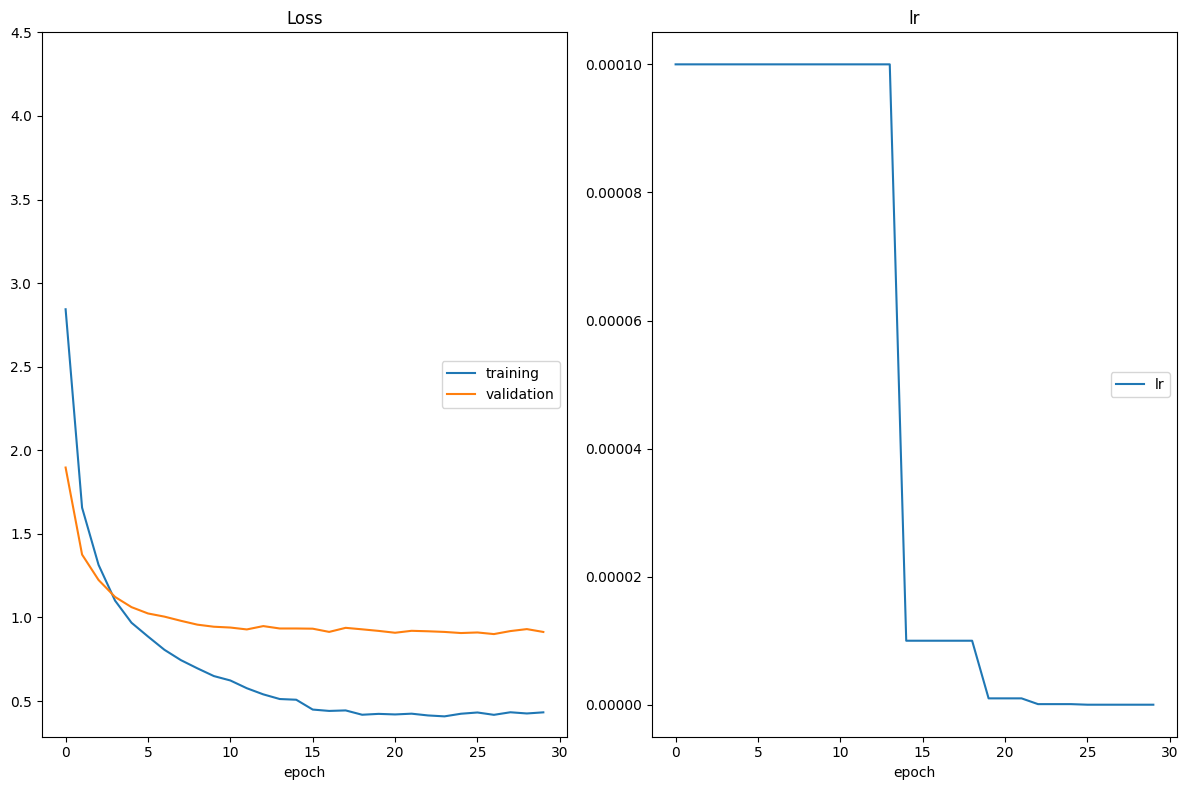

In [2]:
from src.data import get_data_loaders
from src.optimization import get_optimizer, get_loss
from src.train import optimize
from src.transfer import get_model_transfer_learning

model_transfer = get_model_transfer_learning("efficientnet_b4", n_classes=num_classes)

# train the model
data_loaders = get_data_loaders(batch_size=batch_size)
optimizer = get_optimizer(
    model_transfer,
    learning_rate=learning_rate,
    optimizer=opt,
    weight_decay=weight_decay,
)
loss = get_loss()

optimize(
    data_loaders,
    model_transfer,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="checkpoints/model_transfer.pt",
    interactive_tracking=True,
)

In [3]:
# Test Validation Accuracy

import torch
from src.train import one_epoch_test
from src.transfer import get_model_transfer_learning

model_transfer = get_model_transfer_learning("efficientnet_b4", n_classes=num_classes)
# Load saved weights
model_transfer.load_state_dict(torch.load("checkpoints/model_transfer.pt"))

# Load validation dataloader
one_epoch_test(data_loaders["valid"], model_transfer, loss)

Testing: 100%|██████████████████████████████████| 16/16 [00:02<00:00,  6.81it/s]

Test Loss: 0.907251


Test Accuracy: 76% (769/1000)


0.9072511829435825

### Notes about transfer learning model

I chose to use the Efficientnet model architecture as the backbone for my model, particularly the b4 version which has 19.3M parameters. This architecture is relatively small yet has a very good top-1 accuracy of 83% on the ImageNet-1K dataset. Efficientnet was trained on the ImageNet dataset, so the CNN backbone should already have learned many important features of images that are also relevant and important in classifying the Landmark images dataset. The model is also small enough to fit on a GPU with limited memory making it feasible to train with limited compute.

### Further Increasing Accuracy

In [7]:
batch_size = 64  # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.2  # fraction of the training data to reserve for validation
num_epochs = 30  # number of epochs for training
num_classes = 50  # number of classes. Do not change this
learning_rate = 0.0001  # Learning rate for SGD (or Adam)
opt = "adam"  # optimizer. 'sgd' or 'adam'
weight_decay = 0.1  # regularization. Increase this to combat overfitting

In [8]:
# Print layer learning rate from learning rate multiplier
from src import lr_multiplier
from src.transfer import get_model_transfer_learning

model_transfer = get_model_transfer_learning("efficientnet_b4", n_classes=num_classes)
parameters = lr_multiplier.lr_layer_multiplier(
    model_transfer, lr=learning_rate, lr_mult=0.3, verbose=True
)

0: lr = 0.000100, classifier.5.bias
1: lr = 0.000100, classifier.5.weight
2: lr = 0.000100, classifier.2.bias
3: lr = 0.000100, classifier.2.weight
4: lr = 0.000100, classifier.1.bias
5: lr = 0.000100, classifier.1.weight
6: lr = 0.000100, classifier.0.bias
7: lr = 0.000100, classifier.0.weight
8: lr = 0.000030, features.8.1.bias
9: lr = 0.000030, features.8.1.weight
10: lr = 0.000030, features.8.0.weight
11: lr = 0.000009, features.7.1.block.3.1.bias
12: lr = 0.000009, features.7.1.block.3.1.weight
13: lr = 0.000009, features.7.1.block.3.0.weight
14: lr = 0.000009, features.7.1.block.2.fc2.bias
15: lr = 0.000009, features.7.1.block.2.fc2.weight
16: lr = 0.000009, features.7.1.block.2.fc1.bias
17: lr = 0.000009, features.7.1.block.2.fc1.weight
18: lr = 0.000009, features.7.1.block.1.1.bias
19: lr = 0.000009, features.7.1.block.1.1.weight
20: lr = 0.000009, features.7.1.block.1.0.weight
21: lr = 0.000009, features.7.1.block.0.1.bias
22: lr = 0.000009, features.7.1.block.0.1.weight
23: l

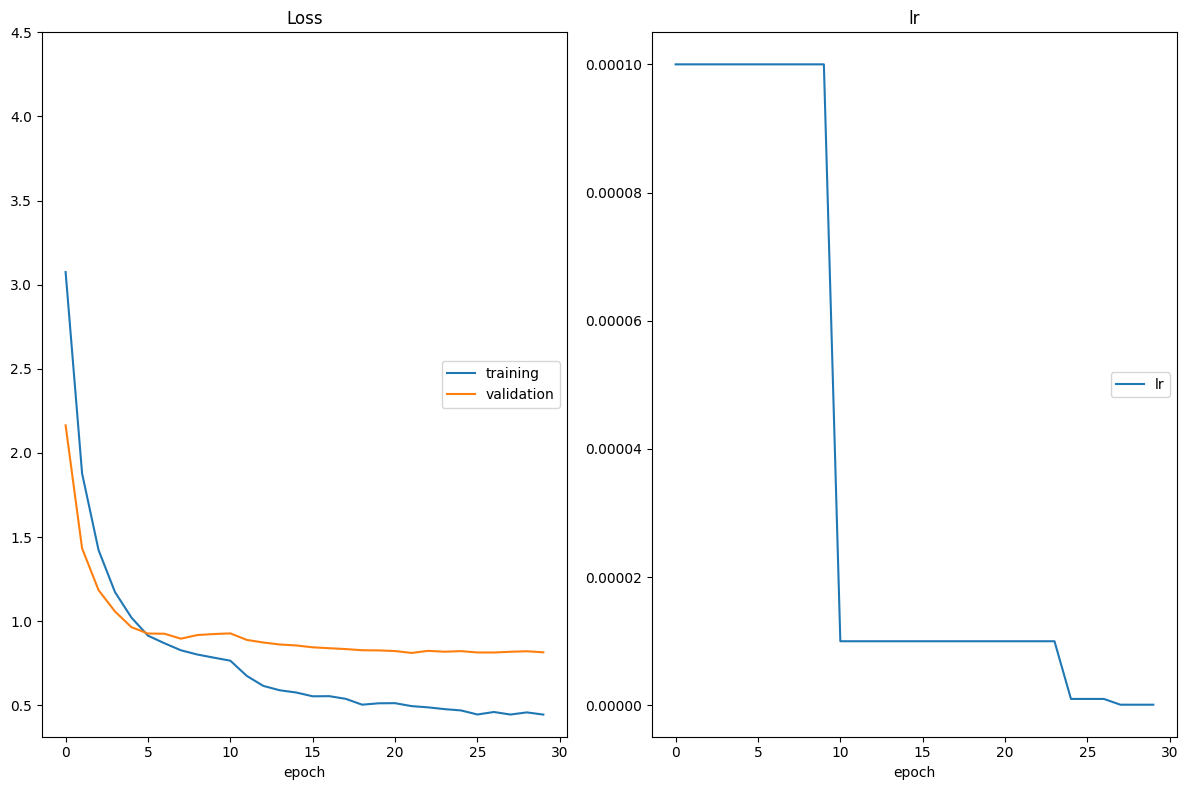

In [9]:
from src.data import get_data_loaders
from src.optimization import get_optimizer, get_loss
from src.train import optimize
from src.transfer import get_model_transfer_learning
from src import lr_multiplier

model_transfer = get_model_transfer_learning("efficientnet_b4", n_classes=num_classes)

for param in model_transfer.parameters():
    param.requires_grad = True

parameters = lr_multiplier.lr_layer_multiplier(
    model_transfer, lr=learning_rate, lr_mult=0.3, verbose=False
)

# train the model
data_loaders = get_data_loaders(batch_size=batch_size)

optimizer = get_optimizer(
    model_transfer,
    learning_rate=learning_rate,
    optimizer=opt,
    weight_decay=weight_decay,
    parameters=parameters,
)
loss = get_loss()

optimize(
    data_loaders,
    model_transfer,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="checkpoints/model_transfer_lr_multiplier.pt",
    interactive_tracking=True,
)

In [10]:
# Test Validation Accuracy

import torch
from src.train import one_epoch_test
from src.transfer import get_model_transfer_learning

model_transfer = get_model_transfer_learning("efficientnet_b4", n_classes=num_classes)
# Load saved weights
model_transfer.load_state_dict(
    torch.load("checkpoints/model_transfer_lr_multiplier.pt")
)

# Load validation dataloader
one_epoch_test(data_loaders["valid"], model_transfer, loss)

Testing: 100%|██████████████████████████████████| 16/16 [00:02<00:00,  6.76it/s]

Test Loss: 0.816501


Test Accuracy: 78% (786/1000)


0.8165013678371906

## Test the Model

In [12]:
# Test Test Accuracy
import torch
from src.train import one_epoch_test
from src.transfer import get_model_transfer_learning

model_transfer = get_model_transfer_learning("efficientnet_b4", n_classes=num_classes)
# Load saved weights
model_transfer.load_state_dict(
    torch.load("checkpoints/model_transfer_lr_multiplier.pt")
)

one_epoch_test(data_loaders["test"], model_transfer, loss)

Testing: 100%|██████████████████████████████████| 20/20 [00:02<00:00,  7.13it/s]

Test Loss: 0.786282


Test Accuracy: 79% (996/1250)


0.7862822800874709

## Export using torchscript

In [13]:
from src.predictor import Predictor
from src.helpers import compute_mean_and_std

# First let's get the class names from our data loaders
class_names = data_loaders["train"].dataset.classes

# Then let's move the model_transfer to the CPU
# (we don't need GPU for inference)
model_transfer = model_transfer.cpu()
# Let's make sure we use the right weights by loading the
# best weights we have found during training
model_transfer.load_state_dict(
    torch.load("checkpoints/model_transfer_lr_multiplier.pt", map_location="cpu")
)

# Let's wrap our model using the predictor class
mean, std = compute_mean_and_std()
predictor = Predictor(model_transfer, class_names, mean, std).cpu()

# Export using torch.jit.script
scripted_predictor = torch.jit.script(predictor)
scripted_predictor.save("checkpoints/transfer_exported.pt")

Reusing cached mean and std


100%|███████████████████████████████████████| 1250/1250 [02:09<00:00,  9.63it/s]


Accuracy: 0.7728


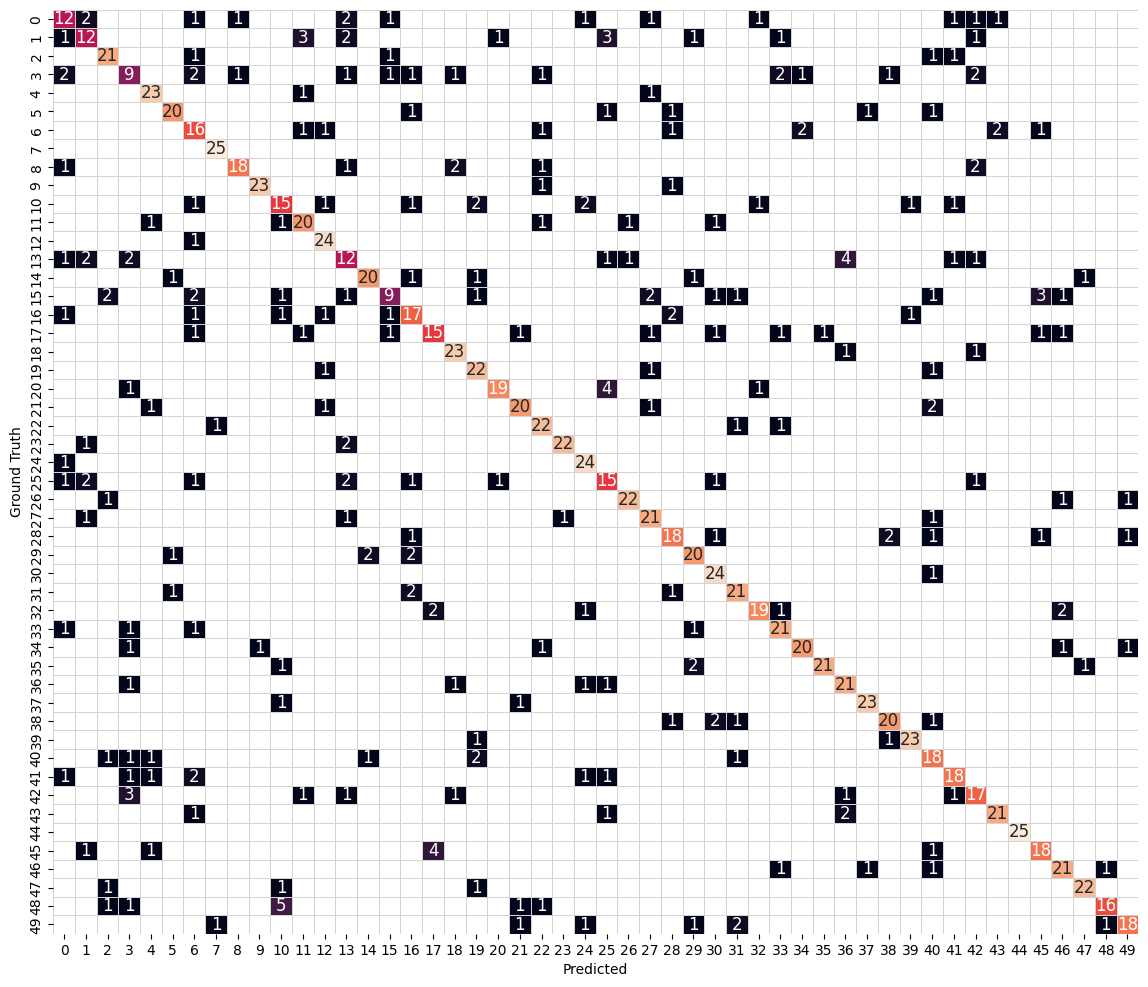

In [14]:
import torch
from src.predictor import predictor_test
from src.helpers import plot_confusion_matrix

model_reloaded = torch.jit.load("checkpoints/transfer_exported.pt")

pred, truth = predictor_test(data_loaders['test'], model_reloaded)

plot_confusion_matrix(pred, truth)